# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1) Data Exploration

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [8]:
print('portfolio Shape {} '.format(portfolio.shape))
print('profile Shape {} '.format(profile.shape))
print('transcript shape{}'.format(transcript.shape))

portfolio Shape (10, 6) 
profile Shape (17000, 5) 
transcript shape(306534, 4)


# 2)Cleaning

i will use cleaning phase to make deep Exploration for data 

# 1-portfolio Cleaning

In [9]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [10]:
# split channels to diffrent columns
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio = portfolio.drop('channels', axis=1)


In [11]:
portfolio.head(1)

,difficulty,duration,id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1


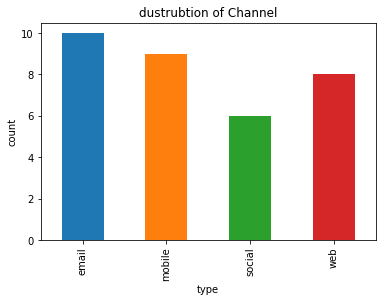

In [12]:
# take deep look in channel dustrubtion
portfolio[['email','mobile','social','web']].sum().plot(kind='bar')
plt.title('dustrubtion of Channel')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

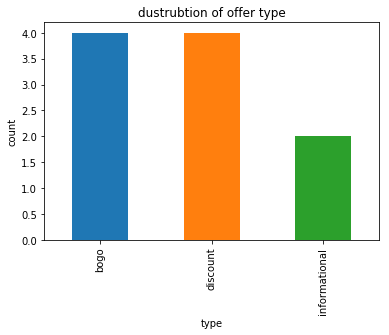

In [13]:
# take deep look in offer type dustrubtion
portfolio.groupby("offer_type")["id"].count().plot(kind='bar')
plt.title('dustrubtion of offer type')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

In [14]:
# rename unkonw id to offer_id
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


# 2-profile Cleaning

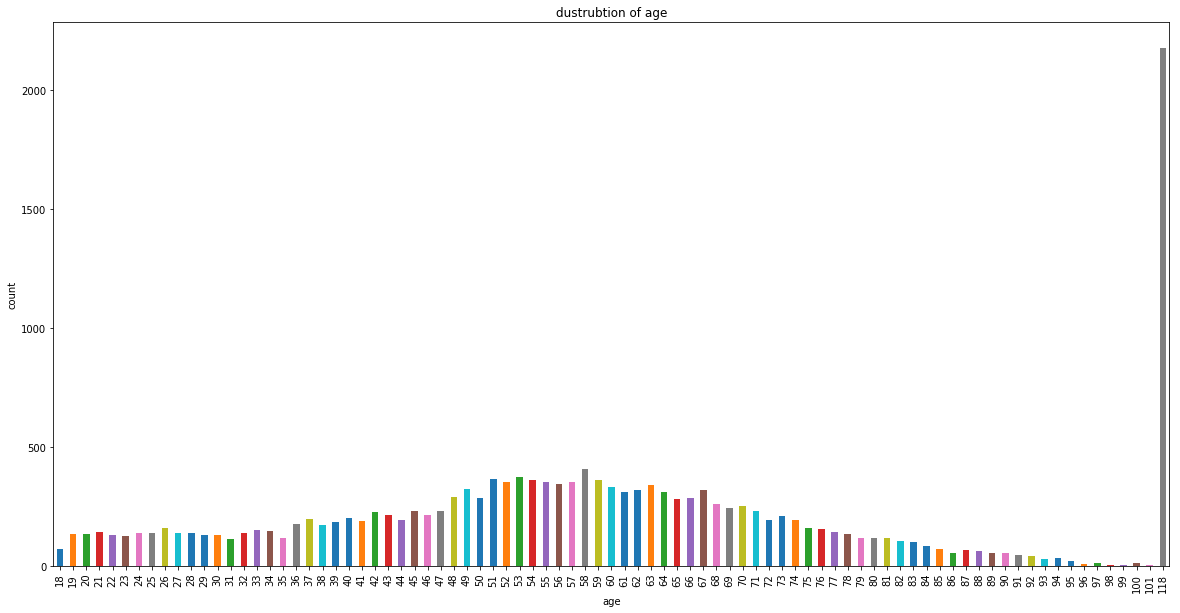

In [15]:
# take deep look in age dustrubtion
profile.groupby('age')['id'].count().plot(kind='bar' ,figsize =(20,10))
plt.title('dustrubtion of age')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

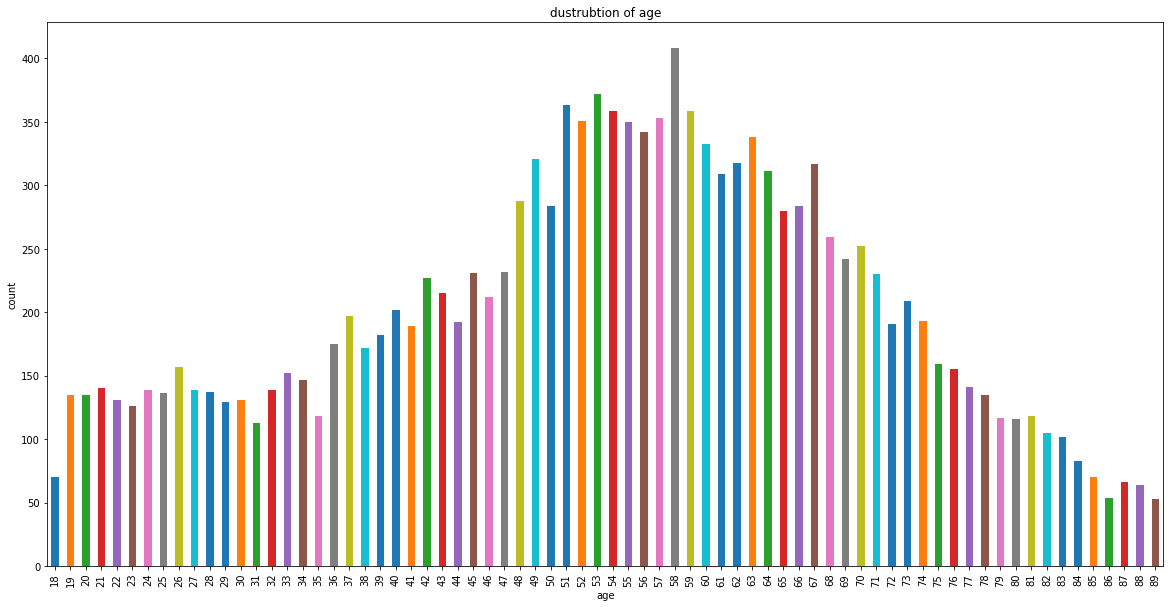

In [16]:
# in previous graph i found outlier then i remove it
profile.drop(profile[profile['age']>= 90].index,inplace=True)
profile.groupby('age')['id'].count().plot(kind='bar' ,figsize =(20,10))
plt.title('dustrubtion of age')
plt.xlabel('age')
plt.ylabel('count')
plt.show()


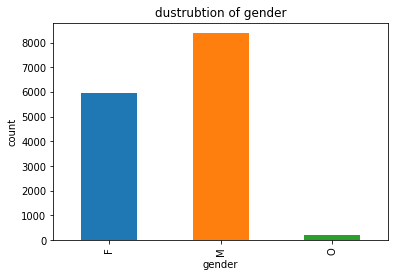

In [17]:
# take deep look in gender dustrubtion
profile.groupby('gender')['id'].count().plot(kind='bar' )
plt.title('dustrubtion of gender')
plt.xlabel('gender')
plt.ylabel('count')
plt.show()

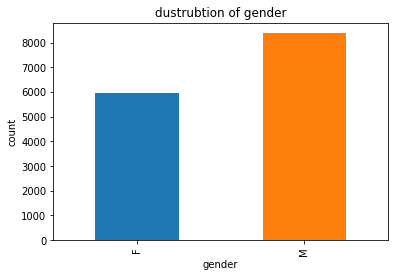

In [18]:
# in  previous graph i found upnormal gender then i remove it
profile.drop(profile[profile['gender']=='O'].index,inplace=True)
profile.groupby('gender')['id'].count().plot(kind='bar' )
plt.title('dustrubtion of gender')
plt.xlabel('gender')
plt.ylabel('count')
plt.show()

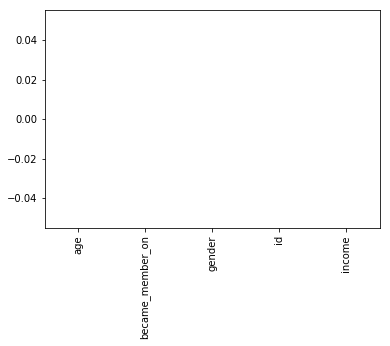

In [19]:
# check null
profile.isnull().sum().plot(kind='bar');

In [20]:
# rename unkonw id to user_id
profile = profile.rename(columns={'id':'user_id'})
profile.head()

,age,became_member_on,gender,user_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


# 3-transcript Cleaning

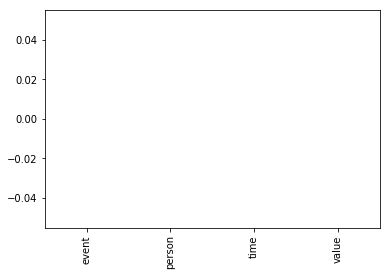

In [21]:
# check null
transcript.isnull().sum().plot(kind='bar');

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
# rename unkonw col to user_id
transcript = transcript.rename(columns={'person':'user_id'})
transcript.head(1)

,event,user_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [24]:
#deep look for value col counts
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [25]:
# prerpar function to clean transcript
def transcript_cleaning (df):
    """
    input:
    parmeter df'data frame name
    output:
    new data frame after add new 2 cols and clean offer_id col
    
    """
    #split cols
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda y: y.get('offer id'))
    df['reward']   = df['value'].apply(lambda z: z.get('reward'))
    df['amount']   = df['value'].apply(lambda e: e.get('amount'))
    #compine offer ids
    df['offer_id'] =df.apply(lambda n: n['offer id']if n['offer_id']== None else n['offer_id'],axis=1)
    #drop no need it cols
    df.drop(['offer id','value'],axis=1,inplace=True)
    #replace nan
    df.fillna(0,inplace=True)
    
    return df


In [26]:
transcript = transcript_cleaning(transcript);
transcript.head()

,event,user_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [27]:
portfolio.head(1)

,difficulty,duration,offer_id,offer_type,reward,email,web,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1


In [28]:
profile.head(1)

,age,became_member_on,gender,user_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [29]:
transcript.head(1)

,event,user_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0


In [30]:
print('portfolio Shape {} '.format(portfolio.shape))
print('profile Shape {} '.format(profile.shape))
print('transcript shape{}'.format(transcript.shape))

portfolio Shape (10, 9) 
profile Shape (14345, 5) 
transcript shape(306534, 6)


# 3) Exploratory Data Analysis (EDA)

In [31]:
#merge DFs
df=portfolio.merge(transcript,on='offer_id');
df= df.merge(profile, on='user_id')
df.head()

,difficulty,duration,offer_id,offer_type,reward_x,email,web,mobile,social,event,user_id,time,reward_y,amount,age,became_member_on,gender,income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0


In [32]:
df.shape

(143893, 18)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143893 entries, 0 to 143892
Data columns (total 18 columns):
difficulty          143893 non-null int64
duration            143893 non-null int64
offer_id            143893 non-null object
offer_type          143893 non-null object
reward_x            143893 non-null int64
email               143893 non-null int64
web                 143893 non-null int64
mobile              143893 non-null int64
social              143893 non-null int64
event               143893 non-null object
user_id             143893 non-null object
time                143893 non-null int64
reward_y            143893 non-null float64
amount              143893 non-null float64
age                 143893 non-null int64
became_member_on    143893 non-null int64
gender              143893 non-null object
income              143893 non-null float64
dtypes: float64(3), int64(10), object(5)
memory usage: 20.9+ MB


# 1-AVG income for user

In [34]:
df['income'].mean()

66353.818462329655

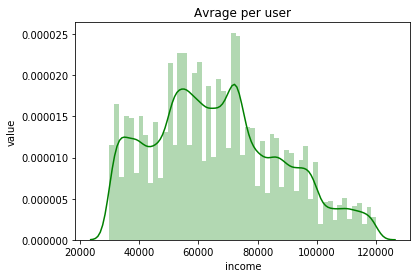

In [35]:
#visualize income for user to see mean
sns.distplot(df['income'],bins=55,hist_kws={'alpha':0.3},color='Green');
plt.title('Avrage per user')
plt.xlabel('income')
plt.ylabel('value')
plt.show()

# 2-Age distribution for users

In [36]:
#makeing tirs for age
conditions = [
    (df['age']<=20),
    (df['age']>20) &(df['age']<=40),
    (df['age']>40)&(df['age']<=60),
    (df['age']>60)&(df['age']<=80),
    (df['age']>80)
]
values = ['under20', '21--40', '40--60', '60--80','above80']
df['age_tirs']=np.select(conditions,values)
df.head()


,difficulty,duration,offer_id,offer_type,reward_x,email,web,mobile,social,event,user_id,time,reward_y,amount,age,became_member_on,gender,income,age_tirs
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0,60--80
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0,60--80
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0,60--80
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0,60--80
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0,60--80


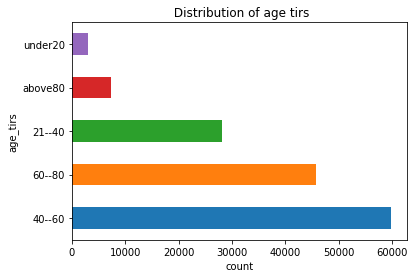

In [37]:
#take deep look for Distribution of age tirs
df['age_tirs'].value_counts().plot(kind='barh',title=' Distribution of age tirs');
plt.xlabel('count')
plt.ylabel('age_tirs')
plt.show()

most of user between 40 and 60 

# 3-Most used offer by the users

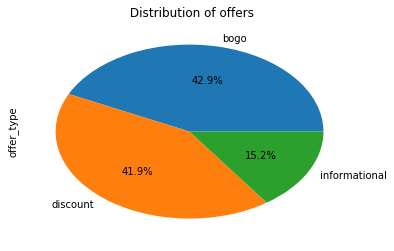

In [38]:
#take deep look for Distribution of offers
df['offer_type'].value_counts().plot.pie(title=' Distribution of offers',autopct='%1.1f%%');


most of users in BOGO and discount with nearly the same distributions

# 4 Actions to the offers that user received

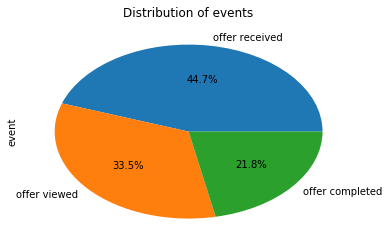

In [39]:
#take deep look for Distribution of events
df['event'].value_counts().plot.pie(title='Distribution of events',autopct='%1.1f%%');

most of users in offer received

# 5 - Distribution of  females & males

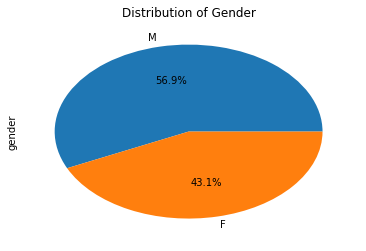

In [40]:
#take deep look for Distribution of events
df['gender'].value_counts().plot.pie(title='Distribution of Gender',autopct='%1.1f%%');

most of users are males

# 6. income of males & females

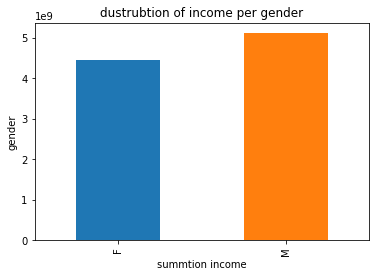

In [41]:
#take deep look for Distribution of income per gender
df.groupby("gender")["income"].sum().plot(kind='bar')
plt.title('dustrubtion of income per gender')
plt.xlabel('summtion income')
plt.ylabel('gender')
plt.show()

# 7. Age tirs of males & females

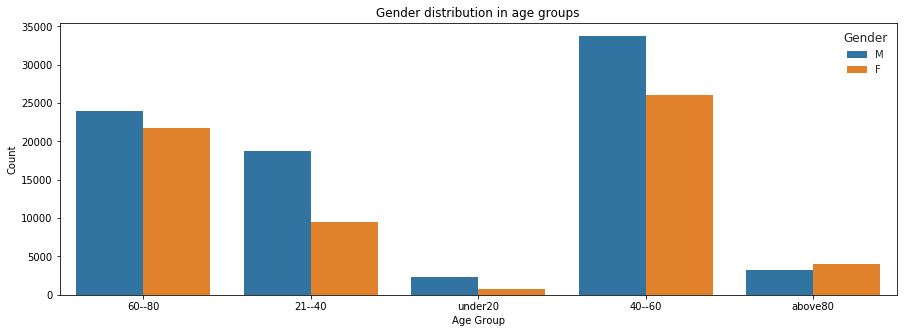

In [42]:
#take deep look for Gender distribution in age groups
plt.figure(figsize=(15, 5))
sns.countplot(x='age_tirs', hue='gender',data=df)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender');


The male users are more than the female ones in each age group, except above80.

# 8. Gender distribution in each offer type

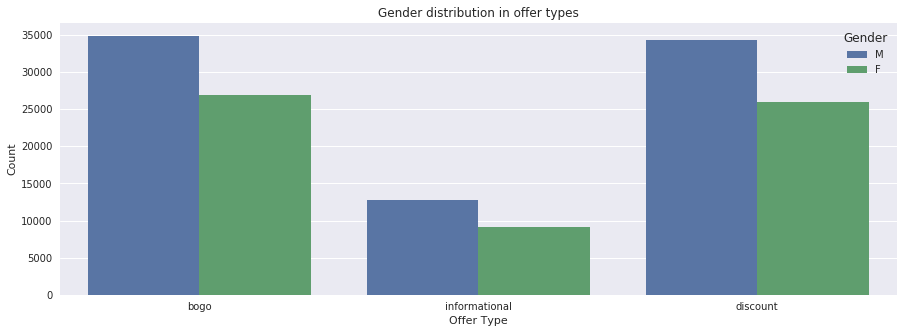

In [43]:
#take deep look for Gender distribution in offer types
plt.figure(figsize=(15,5))
sns.countplot(x='offer_type',hue='gender',data=df)
sns.set(style='whitegrid')
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender');

 The male users are more than the female ones in offer types.

# 9. Actions to the offers that males & females received

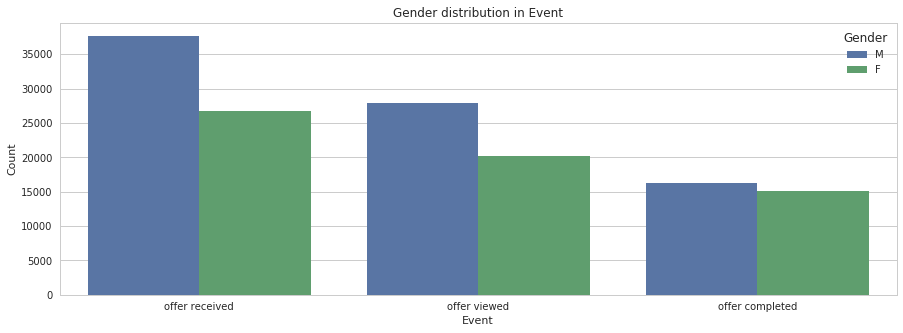

In [44]:
#take deep look for Actions to the offers that males & females received
plt.figure(figsize=(15,5))
sns.countplot(x='event',hue='gender',data=df)
sns.set(style='dark')
plt.title('Gender distribution in Event')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender');

The male users are more than the female ones in Event.

# 10. Actions to the offers in each offer type

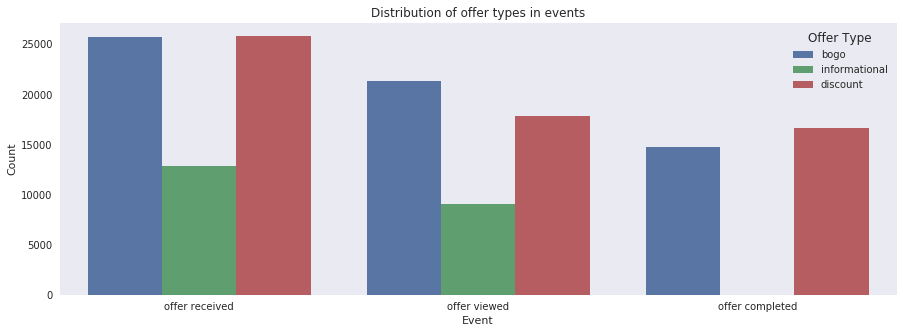

In [45]:
#take deep look for Distribution of offer types in events
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type');

In general, most people take the discount offer

# 11. Actions to the offers in each age group

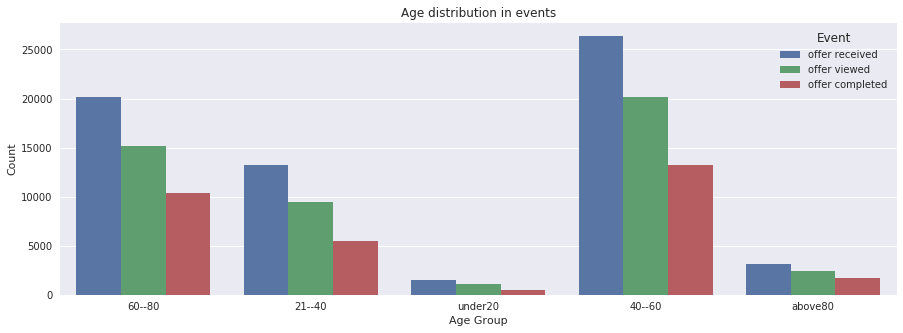

In [46]:
#take deep look for Age distribution in events
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_tirs", hue= "event", data=df)
sns.set(style="white")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event');

the same distubution in each tirs

# 4) Build a Machine Learning model 

# 1- prepar and Clean DF to model

In [47]:
df.head()

,difficulty,duration,offer_id,offer_type,reward_x,email,web,mobile,social,event,user_id,time,reward_y,amount,age,became_member_on,gender,income,age_tirs
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0,60--80
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0,60--80
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0,60--80
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0,60--80
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0,60--80


In [48]:
# make function for final clean
def last_clening(df,cat_col,id_col,numerical_col ):
    """
    input:
    df , categorical cols , ids col, numerical col
    output:
    new data frame for ML  model
    
    """
    
    #change categorical varibles to columns
    for cat_col in cat_col:
        dummies = pd.get_dummies(df[cat_col])
        df = pd.concat([df,dummies], axis = 1)
        df = df.drop(cat_col, axis=1)
        
    df = df.drop('age', axis=1)
    
    #change offer id and user id to numbers.
    for id_col in id_col:
        distinct_x = df[id_col].unique().tolist()
        mapping = dict(zip(distinct_x,range(len(distinct_x))))
        df.replace({id_col:mapping},inplace=True)
    # change col to date formate and extrect month year
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df['became_month']     = df['became_member_on'].apply(lambda x: x.month)
    df['became_year']      = df['became_member_on'].apply(lambda x: x.year)
    df = df.drop('became_member_on',axis=1)
    # use MinMaxScaler to make values between 0,1
    scaler = MinMaxScaler() 
    numerical_col = ['income', 'difficulty', 'duration', 'reward_x', 'time','reward_y','amount']
    df[numerical_col] = scaler.fit_transform(df[numerical_col])
    #prepare X varible 
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df
    

In [49]:
cat_col = ['offer_type', 'gender', 'age_tirs']
id_col = ['offer_id','user_id']
numerical_col = ['income', 'difficulty', 'duration', 'reward_x', 'time','reward_y','amount']

df_ML = last_clening(df,cat_col,id_col,numerical_col)
 

In [50]:
df_ML.head()

,difficulty,duration,offer_id,reward_x,email,web,mobile,social,event,user_id,...,informational,F,M,21--40,40--60,60--80,above80,under20,became_month,became_year
0,0.5,0.571429,0,1.0,1,0,1,1,1,0,...,0,0,1,0,0,1,0,0,9,2017
1,0.5,0.571429,0,1.0,1,0,1,1,2,0,...,0,0,1,0,0,1,0,0,9,2017
2,0.5,0.571429,0,1.0,1,0,1,1,1,0,...,0,0,1,0,0,1,0,0,9,2017
3,0.5,0.571429,0,1.0,1,0,1,1,2,0,...,0,0,1,0,0,1,0,0,9,2017
4,0.5,0.571429,0,1.0,1,0,1,1,3,0,...,0,0,1,0,0,1,0,0,9,2017


In [51]:
df_ML.shape 

(143893, 26)

In [52]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143893 entries, 0 to 143892
Data columns (total 26 columns):
difficulty       143893 non-null float64
duration         143893 non-null float64
offer_id         143893 non-null int64
reward_x         143893 non-null float64
email            143893 non-null int64
web              143893 non-null int64
mobile           143893 non-null int64
social           143893 non-null int64
event            143893 non-null int64
user_id          143893 non-null int64
time             143893 non-null float64
reward_y         143893 non-null float64
amount           143893 non-null float64
income           143893 non-null float64
bogo             143893 non-null uint8
discount         143893 non-null uint8
informational    143893 non-null uint8
F                143893 non-null uint8
M                143893 non-null uint8
21--40           143893 non-null uint8
40--60           143893 non-null uint8
60--80           143893 non-null uint8
above80          

In [53]:
df_ML.event.value_counts()

1    64375
2    48197
3    31321
Name: event, dtype: int64

In [54]:
df_ML['event'].head()

0    1
1    2
2    1
3    2
4    3
Name: event, dtype: int64

# 2. Split train and test data

In [55]:
data=df_ML.drop('event',axis=1);
label=df_ML['event']

In [56]:
#make train and test split
X_train, X_test, y_train, y_test = train_test_split(data,label ,test_size= 0.3 ,random_state=42 )

In [57]:
print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 100725 rows
Testing set: 43168 rows


In [58]:
# make finction for train model
def train_test(ML):
    """
    input:
    model used
    output:
    train and test F1 score with the model name
           
    """
    
    train_prediction =(ML.fit(X_train, y_train)).predict(X_train)
    test_prediction  =(ML.fit(X_train, y_train)).predict(X_test)
    train_f1 =accuracy_score(y_train,train_prediction)*100
    test_f1= fbeta_score(y_test, test_prediction ,beta = 0.5 ,average='micro' )*100
    model_name = ML.__class__.__name__
    return train_f1, test_f1, model_name

In [59]:
ML_1 = KNeighborsClassifier(n_neighbors = 5)
_1_train_f1, _1_test_f1, _1_model_name = train_test(ML_1)

knc = {'Model': [ _1_model_name], 'train F1 score':[_1_train_f1], 'test F1 score': [_1_test_f1]}
knc_result = pd.DataFrame(knc)
knc_result

In [60]:
ML_2 = RandomForestClassifier(random_state = 10)
_2_train_f1, _2_test_f1, _2_model_name = train_test(ML_2)


In [61]:
ML_3 = DecisionTreeClassifier(random_state = 10)
_3_train_f1, _3_test_f1, _3_model_name = train_test(ML_3)

# 5) Conclusion

# 1-Conclusion from EDA

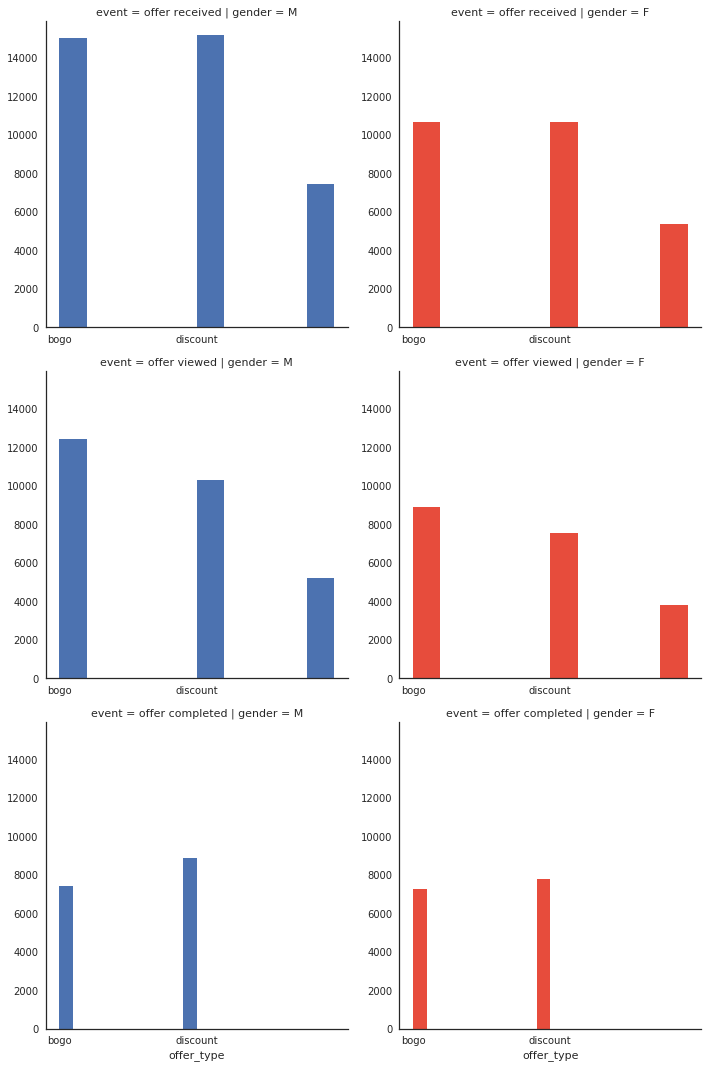

In [62]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(df, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type');

as shown above and in previous analysis the males have good respond to offers and and have high income this happened in all the age tirs in the both cases

Discount and BOGO increase the customer buy rating in the both gender.

#  2-Model comparisons & evaluation against the model metric

In [63]:
models = {'Model': [_1_model_name, _2_model_name, _3_model_name], 
          'train F1 score ':[_1_train_f1, _2_train_f1, _3_train_f1], 
          'test F1 score': [_1_test_f1 , _2_test_f1, _3_test_f1] }
          
models_result = pd.DataFrame(models)
models_result

,Model,train F1 score,test F1 score
0,KNeighborsClassifier,52.438819,30.865456
1,RandomForestClassifier,94.156366,70.651872
2,DecisionTreeClassifier,95.068752,85.257598


 the Best Model is DecisionTreeClassifier  , as its validate F1 score is 85.28 which is much higher than the other models.
 
 RandomForestClassifier is good if we compear it by KNeighborsClassifier ,as its validate F1 score is 71.07.
 
 KNeighborsClassifier is the worst one by F1 score is 30.86.
 
 I think the  scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer. 